In [2]:
import pandas as pd
import seaborn as sns
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from umap import UMAP

/home/benjaminkroeger/.cache/pypoetry/virtualenvs/predictprotein1-solubility-xjW_Baso-py3.10/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/benjaminkroeger/.cache/pypoetry/virtualenvs/predictprotein1-solubility-xjW_Baso-py3.10/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behavio

In [3]:
sol_df = pd.read_csv(r'/home/benjaminkroeger/Documents/Master/Master_2_Semester/Predictprotein2/predictprotein1_solubility/Data/PSI_Biology_solubility_trainset.csv')

In [4]:
sol_df

,sid,solublility|0=Insoluble|1=Soluble,fasta,Partition
0,AaCD00331182,1,MTYKDGTYSSDGTYTSPNGLETVGVELTLAADKVSAVNITVHPSNP...,0.0
1,AaCD00331183,1,MTAMNILVLGSDSRGSSDADVEANTATDQRADTLMLVHVPADRKKT...,1.0
2,AaCD00331184,1,MKAEGNTAMNILVLGSDSRGSSDADVEANTATDQRADTLMLVHVPA...,1.0
3,AaCD00331185,1,MQSFNSGSTKIHNAFPEESTRPQKAEGNTAMNILVLGSDSRGSSDA...,1.0
4,AaCD00331621,1,MNAPVKFEYFKNPKNRELTAVELEAFAKELDQIKQEVLDDIGEKDA...,2.0
...,...,...,...,...
11220,YsCD00591076,1,MEIYVFTPEGRIVELPAGATPVDFAYVVHTDIGHACVGARVDRQPY...,0.0
11221,YsCD00591078,1,MEIYVFTPEGRIVELPAGATPVDFAYVVHTDIGHACVGARVDRQPY...,0.0
11222,YsCD00591079,1,MDLFPDEIYVFTPEGRIVELPAGATPVDFAYVVHTDIGHACVGARV...,0.0
11223,YsCD00665646,1,MVEQEQEAITFEVVAREWHASNRQWSEAHSARVLKSLEDNLFQAIG...,0.0


In [5]:
model_name = r'Rostlab/prot_t5_xl_uniref50'
# load the model in half precision
model = T5EncoderModel.from_pretrained(model_name,torch_dtype=torch.float16)
tokenizer = T5Tokenizer.from_pretrained(model_name ,do_lower_case=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.1.layer.1.EncDecAttention.o.weight', 'decoder.block.15.layer.0.layer_norm.weight', 'decoder.block.11.layer.0.SelfAttention.q.weight', 'decoder.block.4.layer.1.EncDecAttention.q.weight', 'decoder.block.13.layer.2.DenseReluDense.wi.weight', 'decoder.block.8.layer.1.layer_norm.weight', 'decoder.block.2.layer.0.SelfAttention.v.weight', 'decoder.block.19.layer.1.EncDecAttention.q.weight', 'decoder.block.10.layer.1.EncDecAttention.o.weight', 'decoder.block.22.layer.2.DenseReluDense.wi.weight', 'decoder.block.1.layer.1.EncDecAttention.v.weight', 'decoder.block.16.layer.0.SelfAttention.k.weight', 'decoder.block.22.layer.2.layer_norm.weight', 'decoder.block.0.layer.0.layer_norm.weight', 'decoder.block.4.layer.1.EncDecAttention.o.weight', 'decoder.block.7.layer.0.SelfAttention.k.weight', 'decoder.block.9.layer.0.SelfAttention.o.weight', 'decoder.block.11.layer.2.Den

In [6]:
def create_embeddings(sequences:list,tokenizer : T5Tokenizer,model:T5EncoderModel,device:torch.device)->torch.tensor:

    # clean seqs
    sequences = [" ".join(list(re.sub(r"[UZOB]", "X", sequence))) for sequence in sequences]
    ids = tokenizer.batch_encode_plus(sequences, add_special_tokens=True, padding="longest")
    input_ids = torch.tensor(ids['input_ids']).to(device)
    attention_mask = torch.tensor(ids['attention_mask']).to(device)
    model = model.to(device)
    with torch.no_grad():
        embedding_repr = model(input_ids=input_ids,attention_mask=attention_mask)


    return_tensor= []
    for i in range(len(sequences)):
        return_tensor.append(embedding_repr.last_hidden_state[i,:sum(attention_mask[i])].mean(dim=0))

    return torch.stack(return_tensor)

In [7]:
redo_embedds = False
if redo_embedds:
    start_pos = 1000
    batch_size = 5
    total= 4001
    embedd_tensor = create_embeddings(sequences=sol_df['fasta'].tolist()[:batch_size],model=model,tokenizer=tokenizer,device=device)
    for i in tqdm(range(start_pos,start_pos+ total,batch_size)):
        embedd_tensor_new = create_embeddings(sequences=sol_df['fasta'].tolist()[i:i+batch_size],model=model,tokenizer=tokenizer,device=device)
        embedd_tensor = torch.concat((embedd_tensor, embedd_tensor_new))

    file = h5py.File('/home/benjaminkroeger/Documents/Master/Master_2_Semester/Predictprotein2/predictprotein1_solubility/Data/All_embedds.h5','w')
    file.create_dataset('embedds',data=embedd_tensor.cpu())
    file.close()

else:
    h5_embedds = h5py.File('/home/benjaminkroeger/Documents/Master/Master_2_Semester/Predictprotein2/predictprotein1_solubility/Data/All_embedds_5000.h5','r')
    embedd_tensor = torch.tensor(h5_embedds.get('embedds')).cpu()

/tmp/ipykernel_17215/2750044279.py:17: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  embedd_tensor = torch.tensor(h5_embedds.get('embedds')).cpu()


In [8]:
embedd_tensor.shape

torch.Size([5015, 1024])

In [9]:
t_sne_df = pd.DataFrame(embedd_tensor.to('cpu'))
t_sne_df['solubility'] = sol_df['solublility|0=Insoluble|1=Soluble']

<Axes: xlabel='Dimension 1', ylabel='Dimension 2'>

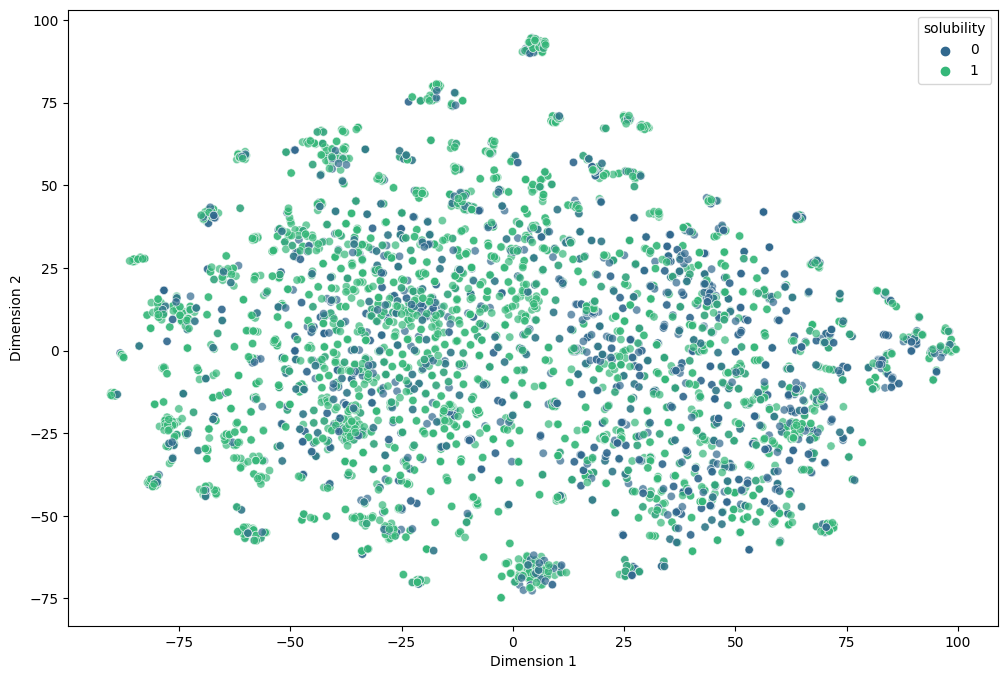

In [10]:
tnse = TSNE(n_components=2, random_state=10)
projections = tnse.fit_transform(t_sne_df[range(1024)])


plot_df_tsne = pd.DataFrame(projections, columns=['Dimension 1', 'Dimension 2'])
plot_df_tsne['solubility'] = t_sne_df['solubility']

fig, axes = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=plot_df_tsne, x='Dimension 1', y='Dimension 2', hue='solubility', palette='viridis',alpha=0.7,ax=axes)

<Axes: xlabel='solubility', ylabel='Count'>

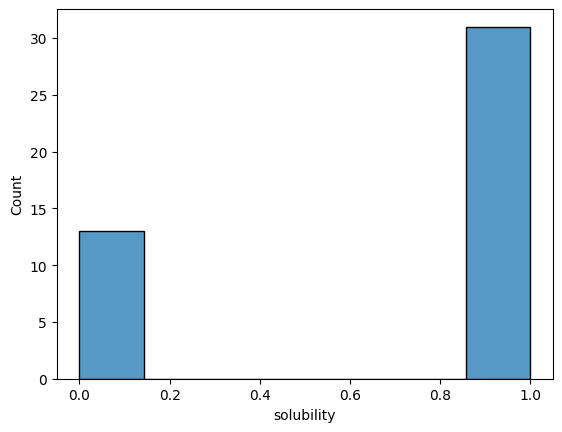

In [11]:
sns.histplot(data=plot_df_tsne[plot_df_tsne['Dimension 2']>90]['solubility'])

In [12]:
#plot_df_tsne[(plot_df_tsne['solubility']==1) & (plot_df_tsne['Dimension 2']>90)]
plot_df_tsne[(plot_df_tsne['Dimension 2']>90)]

,Dimension 1,Dimension 2,solubility
69,6.546540,90.273109,1
72,6.649045,90.204338,1
508,4.414654,90.575974,1
509,4.824759,90.167976,1
511,4.167358,90.085808,1
1058,2.901038,91.367760,0
1059,3.802901,90.433914,0
1060,4.168048,90.086388,0
1324,2.153751,90.384399,1
1325,2.992116,91.017143,1


In [14]:
with open('cluster.fasta','w') as f:
    counter = 0
    for line in sol_df.iloc[plot_df_tsne[(plot_df_tsne['solubility']==1) & (plot_df_tsne['Dimension 2']>90)].index]['fasta']:
    #for line in sol_df.iloc[plot_df_tsne[(plot_df_tsne['Dimension 2']>90)].index]['fasta']:
        f.write(f'>fasta{counter}\n')
        counter += 1
        f.write(line + '\n')

<Axes: xlabel='Dimension 1', ylabel='Dimension 2'>

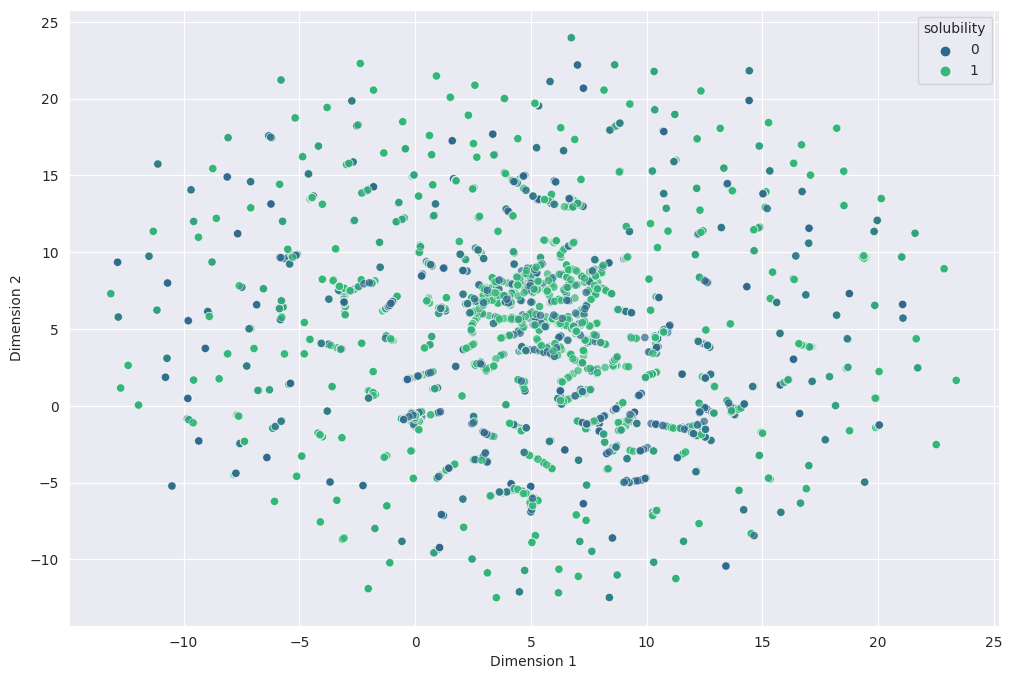

In [14]:
umap_2d = UMAP(n_components=2, init='random', random_state=0,n_neighbors=4)
projections = umap_2d.fit_transform(t_sne_df[range(1024)])


plot_df_umap = pd.DataFrame(projections, columns=['Dimension 1', 'Dimension 2'])
plot_df_umap['solubility'] = t_sne_df['solubility']

fig, axes = plt.subplots(figsize=(12, 8))
sns.scatterplot(data=plot_df_umap, x='Dimension 1', y='Dimension 2', hue='solubility', palette='viridis',ax=axes,alpha=0.7)